# Distilbert-base-cased, dropping tokens beyond 512 words

Note that not all the cells in this notebook has outputs shown, because it is converted to an `.py` file and run in the SoC slurm clusters, then the model and results are copied back. But the notebook can be run here.

In [6]:
import string

import torch

torch.cuda.empty_cache()

import gc

gc.collect()

0

In [7]:
SAVE_LOCATION = "results_distilbert_full_droplong"

from pathlib import Path

Path(SAVE_LOCATION).mkdir(parents=True, exist_ok=True)

In [8]:
import nltk
import swifter
import string
import pandas as pd
import numpy as np

nltk.download("punkt")

C:\Users\Ian\miniconda3\envs\CS4248\lib\site-packages\dask\dataframe\_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Ian\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [9]:
df = pd.read_csv('raw_data/fulltrain.csv', names=["labels", "text"])
balanced_test = pd.read_csv('raw_data/balancedtest.csv', names=["labels", "text"])

In [10]:
def text_preprocess(text: str):
    tokens = nltk.word_tokenize(text)
    tokens = [word for word in tokens if word not in string.punctuation]
    length = len(tokens)
    return pd.Series({"text": text, "len": len(tokens)})


text_and_len = df["text"].swifter.apply(text_preprocess)
df.drop("text", axis=1, inplace=True)
df = pd.concat([df, text_and_len], axis=1)

Pandas Apply:   0%|          | 0/48854 [00:00<?, ?it/s]

In [11]:
df["labels"] -= 1
balanced_test["labels"] -= 1

In [12]:
df

,labels,text,len
0,0,"A little less than a decade ago, hockey fans w...",146
1,0,The writers of the HBO series The Sopranos too...,124
2,0,Despite claims from the TV news outlet to offe...,711
3,0,After receiving 'subpar' service and experienc...,716
4,0,After watching his beloved Seattle Mariners pr...,178
...,...,...,...
48849,3,The ruling Kuomintang (KMT) has claimed owners...,632
48850,3,The Taipei city government has encouraged the ...,277
48851,3,President Ma Ying-jeou said Friday that a park...,410
48852,3,The families of the four people who were kille...,246


In [15]:
text_and_len2 = balanced_test["text"].swifter.apply(text_preprocess)
balanced_test.drop("text", axis=1, inplace=True)
balanced_test = pd.concat([balanced_test, text_and_len2], axis=1)
balanced_test

Pandas Apply:   0%|          | 0/3000 [00:00<?, ?it/s]

,labels,text,len
0,0,When so many actors seem content to churn out ...,251
1,0,In what football insiders are calling an unex...,202
2,0,In a freak accident following Game 3 of the N....,167
3,0,North Koreas official news agency announced to...,134
4,0,The former Alaska Governor Sarah Palin would b...,177
...,...,...,...
2995,3,The Air Force mistakenly gave rival companies ...,591
2996,3,The United Nations climate chief on Friday cha...,351
2997,3,River Plate midfielder Diego Buonanotte has un...,98
2998,3,Lawmakers were on the brink Tuesday of exempti...,622


In [16]:
df["labels"].value_counts()

labels
2    17870
0    14047
3     9995
1     6942
Name: count, dtype: int64

In [20]:
df_dropped = df.drop(df[df.len > 512].index)
df_dropped.labels.value_counts()

labels
0    10331
2     7012
1     6913
3     6697
Name: count, dtype: int64

In [21]:
df = df_dropped

In [22]:
balanced_test_dropped = balanced_test.drop(balanced_test[balanced_test.len > 512].index)
balanced_test_dropped.labels.value_counts()

labels
0    746
1    489
3    375
2    181
Name: count, dtype: int64

In [23]:
balanced_test = balanced_test_dropped

In [24]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-cased")

In [25]:
def preprocess_function(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        max_length=512,
        padding="max_length",
        return_tensors="pt"
    )

In [26]:
from datasets import Dataset

df_dataset = Dataset.from_pandas(df)

In [27]:
tokenized_df = df_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/30953 [00:00<?, ? examples/s]

In [28]:
tokenized_df

Dataset({
    features: ['labels', 'text', 'len', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 30953
})

In [29]:
from transformers import DataCollatorWithPadding, DataCollator

data_collator = DataCollatorWithPadding(tokenizer)

In [ ]:
import numpy as np
from transformers import EvalPrediction
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


def compute_metrics(p: EvalPrediction):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="macro")
    accuracy = accuracy_score(labels, predictions)
    return {
        "accuracy": accuracy,
        "f1": f1,
        "precision": precision,
        "recall": recall
    }

In [33]:
id2label = {0: "0", 1: "1", 2: "2", 3: "3"}
label2id = {v: k for k, v in id2label.items()}

In [34]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert/distilbert-base-cased", num_labels=4, id2label=id2label, label2id=label2id
)

Some weights of the model checkpoint at distilbert/distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-cased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'pre_classifier.weigh

In [35]:
test_df = Dataset.from_pandas(balanced_test)
tokenized_test_df = test_df.map(preprocess_function, batched=True)


Map:   0%|          | 0/1791 [00:00<?, ? examples/s]

In [ ]:
training_args = TrainingArguments(

    output_dir=SAVE_LOCATION,
    # learning_rate=5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=4,
    # weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",

    logging_dir="logs",
    logging_steps=100,

    load_best_model_at_end=True,
    metric_for_best_model="f1",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_df,
    eval_dataset=tokenized_test_df,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

In [ ]:
trainer.train()

In [ ]:
trainer.evaluate()

In [ ]:
trainer.save_model(SAVE_LOCATION)
tokenizer.save_pretrained(SAVE_LOCATION)

In [ ]:
loaded_model = AutoModelForSequenceClassification.from_pretrained(f"{SAVE_LOCATION}/")
loaded_tokenizer = AutoTokenizer.from_pretrained(f"{SAVE_LOCATION}/")

In [ ]:
from transformers import pipeline

classifier = pipeline("text-classification",
                      model=loaded_model,
                      tokenizer=loaded_tokenizer, max_length=512,
                      truncation=True,
                      device_map="auto",
                      )

# Predicting on the balanced test set

In [ ]:
balanced_test = pd.read_csv('raw_data/balancedtest.csv', names=["labels", "text"])
balanced_test["labels"] -= 1


In [ ]:
from tqdm import tqdm
from transformers.pipelines.base import KeyDataset
from datasets import Dataset


def get_results(df: pd.DataFrame) -> pd.Series:
    results = []
    test_df = Dataset.from_pandas(df)
    for out in tqdm(classifier(KeyDataset(test_df, "text"))):
        extracted_label = out["label"]
        results.append(extracted_label)
    return pd.Series(results)



In [ ]:
# without dropping long
baseline = get_results(balanced_test)

In [ ]:
from sklearn.metrics import classification_report

report_baseline = classification_report(balanced_test["labels"], baseline.astype(int))
print(report_baseline)

"""
              precision    recall  f1-score   support

           0       0.86      0.91      0.88       750
           1       0.94      0.84      0.89       750
           2       0.05      0.01      0.01       750
           3       0.51      0.96      0.66       750

    accuracy                           0.68      3000
   macro avg       0.59      0.68      0.61      3000
weighted avg       0.59      0.68      0.61      3000
"""

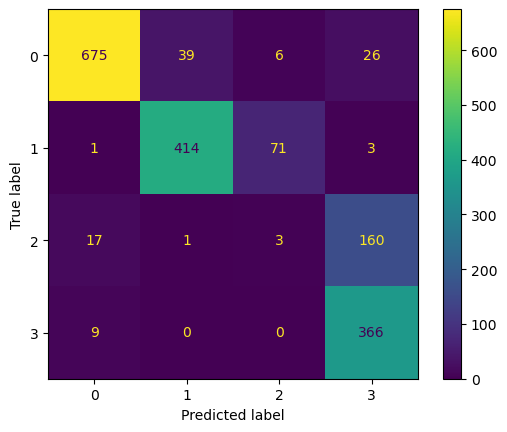

In [39]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(balanced_test["labels"].astype(int), balanced_test["pred"].astype(int))
ConfusionMatrixDisplay(cm).plot()